In [10]:
import numpy as np

def generateData(noise_factor, data, labels):
    current_noise = noise_factor

    x = []
    y = []
    z = []

    last = data

    while current_noise < 1:

        noised = data + current_noise * np.random.normal(loc=0.0, scale=1.0, size=data.shape)
        noised = np.clip(noised, 0., 1.)

        x.append(noised)
        y.append(last)
        z.append(labels)

        last = noised

        current_noise += noise_factor
    
    x = np.array(x)
    y = np.array(y)
    z = np.array(z)

    x = x.reshape(x.shape[0] * x.shape[1],-1)
    y = y.reshape(y.shape[0] * y.shape[1],-1)
    z = z.reshape(z.shape[0] * z.shape[1],-1)

    perm = np.random.permutation(len(x))

    return (x[perm], y[perm], z[perm])

In [12]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from keras.utils import to_categorical
# Load MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Preprocess the data
x_train = x_train.reshape((len(x_train), 28 * 28)).astype('float32') / 255
x_test = x_test.reshape((len(x_test), 28 * 28)).astype('float32') / 255

# Add noise to the images (optional, but useful for denoising autoencoder)
noise_factor = 0.1

# Use the same data for input and target (denoising autoencoder)
train_labels = to_categorical(y_train, num_classes=10)
test_labels = to_categorical(y_test, num_classes=10)

x_train, y_train, l_train = generateData(noise_factor, x_train, train_labels)
x_test, y_test, l_test = generateData(noise_factor, x_test, test_labels)


# Print the shape of the data
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)
print("l_train shape:", l_train.shape)
print("l_test shape:", l_test.shape)

x_train shape: (600000, 784)
x_test shape: (100000, 784)
y_train shape: (600000, 784)
y_test shape: (100000, 784)
l_train shape: (600000, 10)
l_test shape: (100000, 10)


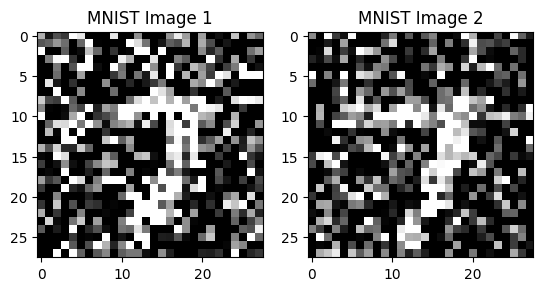

In [13]:
import numpy as np
import matplotlib.pyplot as plt

plt.subplot(1, 2, 1)
plt.imshow(x_test[0].reshape(28, 28), cmap='gray')
plt.title('MNIST Image 1')

plt.subplot(1, 2, 2)
plt.imshow(y_test[0].reshape(28, 28), cmap='gray')
plt.title('MNIST Image 2')

plt.show()



In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from keras import layers, models

def diffusion_with_conditioning():
    noise_input = layers.Input(shape=(28 * 28,))
    label_input = layers.Input(shape=(10,))  # Assuming 10 classes for digits 0-9

    # Concatenate noise input with label
    concatenated_input = layers.concatenate([noise_input, label_input])

    x = layers.Dense(28*28, activation='relu')(concatenated_input)
    x = layers.Dense(28*28, activation='relu')(x)
    generated_image = layers.Dense(28*28, activation='sigmoid')(x)

    model = models.Model(inputs=[noise_input, label_input], outputs=generated_image)

    return model


def create_autoencoder():
    autoencoder_model = diffusion_with_conditioning()
    autoencoder_model.compile(optimizer='adam', loss='mse')  # Use appropriate loss function
    return autoencoder_model

def train(model,x,y):
    model.fit(x, y, epochs=10, batch_size=128)  # Adjust epochs and batch_size

autoencoder_model = create_autoencoder()
train(autoencoder_model, [x_train, train_labels], y_train)


Epoch 1/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0458
Epoch 2/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0321
Epoch 3/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0292
Epoch 4/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0274
Epoch 5/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0258
Epoch 6/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0246
Epoch 7/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0236
Epoch 8/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0226
Epoch 9/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0217
Epoch 10/10
469/469 [==============================] - 1s 2ms/step - loss: 0.0210


313/313 [==============================] - 0s 767us/step


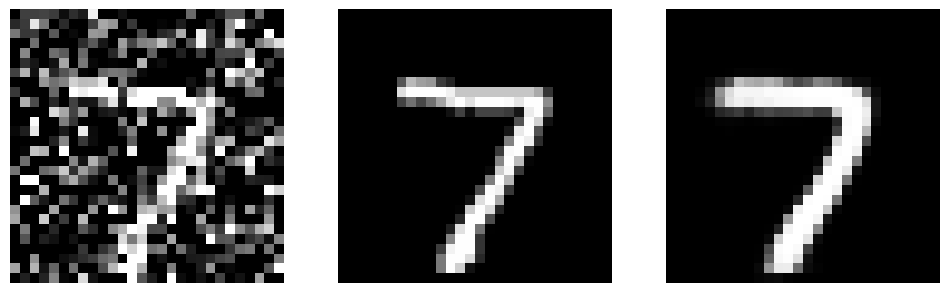

In [42]:
import matplotlib.pyplot as plt



noisy_image = x_test[0].reshape(28, 28)
original_image = y_test[0].reshape(28, 28)
recovered_image = autoencoder_model.predict([x_test,test_labels])[0].reshape(28, 28)



fig, axs = plt.subplots(1, 3, figsize=(12, 4), squeeze=False)

# Plot the noisy image on the first subplot
axs[0, 0].imshow(noisy_image.astype('float'), cmap='gray')
# axs[0, 0].set_title('MNIST Image 1')

# Plot the original image on the second subplot
axs[0, 1].imshow(original_image.astype('float'), cmap='gray')
# axs[0, 1].set_title('MNIST Image 2')

# Plot the recovered image on the third subplot
axs[0, 2].imshow(recovered_image.astype('float'), cmap='gray')
# axs[0, 2].set_title('MNIST Image 3')

# Hide axes and tick labels for all subplots
for ax in axs[0]:
    ax.axis('off')

plt.show()

1/1 [==============================] - 0s 13ms/step


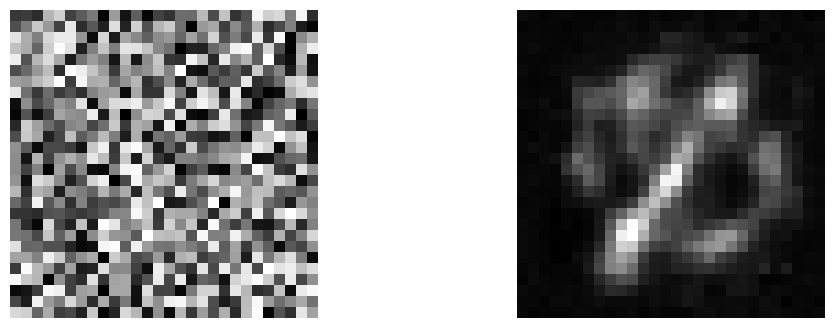

In [44]:
import matplotlib.pyplot as plt



image = np.array([np.random.rand(784)])
label = np.array([[0,1,0,0,0,0,0,0,0,0]])

recovered_image = autoencoder_model.predict([image,label])[0].reshape(28, 28)

fig, axs = plt.subplots(1, 2, figsize=(12, 4), squeeze=False)
axs[0, 0].imshow(image.reshape(28,28).astype('float'), cmap='gray')
axs[0, 1].imshow(recovered_image.astype('float'), cmap='gray')
for ax in axs[0]:
    ax.axis('off')

plt.show()